# Data Preparation

In [3]:
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    col, count, when, lit
)

import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib

spark = SparkSession.builder \
    .master("local") \
    .appName("master-covid") \
    .getOrCreate()
spark.sparkContext.setLogLevel("FATAL")

In [4]:
PATH_DATA = 'datas'
PATH_RESULT = 'results'

In [3]:
df = spark.read.parquet(f'{PATH_DATA}/trusted.parquet')

get only year 2020-2021 with CLASSI_FIN = 5 (COVID-19)

In [5]:
df = df.filter(
    col('SOURCE_YEAR').isin([2020, 2021]) & (col('CLASSI_FIN') == 5)
)

## C1 - outcome

### Missing values

get missing

In [6]:
missing = df.select([
    (count(when(col(c).isNull(), c))/count(lit(1))).alias(c)
    for c in df.columns
]).first()

drop fields with missing > 50%

In [7]:
cols_drop = [c for c in missing.asDict() if missing[c] > 0.5]
cols_drop.sort()
print(cols_drop)
df = df.drop(*cols_drop)

['AN_ADENO', 'AN_OUTRO', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_SARS2', 'AN_VSR', 'ARTRALGIA', 'ASMA', 'AVE_10_DIA', 'CALAFRIO', 'CARDIOPATI', 'CLASSI_OUT', 'CONJUNTIV', 'CORIZA', 'CO_LAB_IF', 'CO_LAB_PCR', 'CO_PS_VGM', 'CO_UF_INTE', 'CS_ETINIA', 'CULT_AMOST', 'CULT_OUT', 'CULT_RES', 'DIABETES', 'DOENCA_TRA', 'DOSE_1_COV', 'DOSE_2_COV', 'DS_AN_OUT', 'DS_IF_OUT', 'DS_OAGEETI', 'DS_OUTMET', 'DS_OUTSUB', 'DS_PCR_OUT', 'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_CO_SOR', 'DT_CULTURA', 'DT_DOSEUNI', 'DT_ENTUTI', 'DT_HEMAGLU', 'DT_IF', 'DT_IFI', 'DT_OBITO', 'DT_OUTMET', 'DT_PCR_1', 'DT_RAIOX', 'DT_RES', 'DT_RES_AN', 'DT_RT_VGM', 'DT_SAIDUTI', 'DT_TOMO', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_VGM', 'ESTRANG', 'FLUASU_OUT', 'FLUBLI_OUT', 'FNT_IN_COV', 'HEMATOLOGI', 'HEMA_ETIOL', 'HEMA_RES', 'HEMOGLOBI', 'HEM_TIPO_H', 'HEM_TIPO_N', 'HEPATICA', 'ID_OCUPA_N', 'IFI', 'IF_ADENO', 'IF_OUTRO', 'IF_PARA1', 'IF_PARA2', 'IF_PARA3', 'IF_RESUL', 'IF_VSR', 'IMUNODEPRE', 'LAB_IF', 'LAB_PCR', 'LAB_PR_COV', 'LOTE_1

store

In [5]:
# df.write.mode('overwrite').parquet(f'{PATH_DATA}/prepare/c1/0-missing-values.parquet')
df = spark.read.parquet(f'{PATH_DATA}/prepare/c1/0-missing-values.parquet')
len(df.columns)

71

plot missing values

In [9]:
missing_df = pd.Series({
    k: v for k,v in missing.asDict().items()
    if k in df.columns and k != 'SOURCE_YEAR'
})

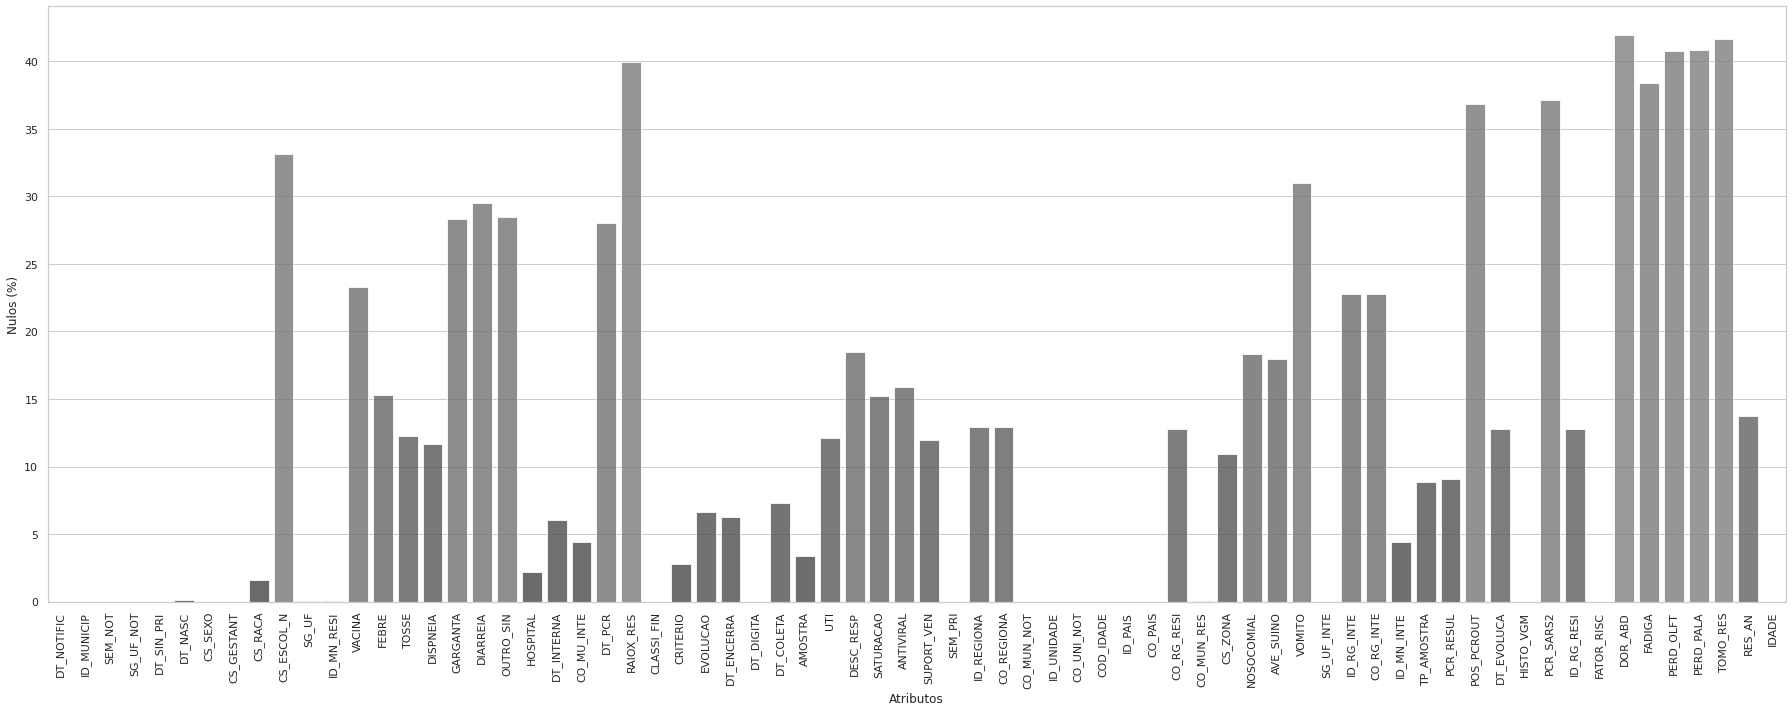

In [10]:
sns.set(style="whitegrid", color_codes=True)
# pal = sns.color_palette("Greens_d", len(missing))
# pal = sns.color_palette("ch:s=0,rot=0", len(missing))
pal = sns.color_palette("dark:grey_r", len(missing_df))
rank = missing_df.values.argsort().argsort()

plt.figure(figsize=(25,10))
ax = sns.barplot(x=missing_df.index, y=missing_df.values*100, palette=np.array(pal[::-1])[rank], alpha=0.8)
# plt.title('Porcentagem de valores nulos')
plt.ylabel('Nulos (%)', fontsize=12)
plt.xlabel('Atributos', fontsize=12)
plt.xticks(rotation=90)

fig = ax.get_figure()
plt.tight_layout()

out = f'{PATH_RESULT}/plots/missing/c1'
pathlib.Path(out).mkdir(parents=True, exist_ok=True)

fig.savefig(f'{out}/percent.png')
plt.show()

### Feature selection

In [11]:
cols_drop = [
    'DT_NOTIFIC',
    'ID_MUNICIP',
    'SEM_NOT',
    'SG_UF_NOT',
    'DT_SIN_PRI',
    'DT_NASC',
    # 'CS_SEXO',
    'CS_GESTANT',
    'CS_RACA',
    'CS_ESCOL_N',
    'SG_UF',
    'ID_MN_RESI',
    'VACINA',
    'OUTRO_SIN',
    'HOSPITAL',
    'DT_INTERNA',
    'CO_MU_INTE',
    'DT_PCR',
    'RAIOX_RES',
    'CLASSI_FIN',
    'CRITERIO',
    'DT_ENCERRA',
    'DT_DIGITA',
    'DT_COLETA',
    'AMOSTRA',
    'UTI',
    'ANTIVIRAL',
    'SUPORT_VEN',
    'SEM_PRI',
    'ID_REGIONA',
    'CO_REGIONA',
    'CO_MUN_NOT',
    'ID_UNIDADE',
    'CO_UNI_NOT',
    'COD_IDADE',
    'ID_PAIS',
    'CO_PAIS',
    'CO_RG_RESI',
    'CO_MUN_RES',
    'CS_ZONA',
    'NOSOCOMIAL',
    'AVE_SUINO',
    'SG_UF_INTE',
    'ID_RG_INTE',
    'CO_RG_INTE',
    'ID_MN_INTE',
    'TP_AMOSTRA',
    'PCR_RESUL',
    'POS_PCROUT',
    'DT_EVOLUCA',
    'HISTO_VGM',
    'PCR_SARS2',
    'ID_RG_RESI',
    'FATOR_RISC',
    'TOMO_RES',
    'RES_AN',
    'SOURCE_YEAR',
]
df = df.drop(*cols_drop)
df.columns

['CS_SEXO',
 'FEBRE',
 'TOSSE',
 'DISPNEIA',
 'GARGANTA',
 'DIARREIA',
 'EVOLUCAO',
 'DESC_RESP',
 'SATURACAO',
 'VOMITO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'IDADE']

In [12]:
df.write.mode('overwrite').parquet(f'{PATH_DATA}/prepare/c1/1-feature-selection.parquet')

#### Plots

In [13]:
aux = df.toPandas()

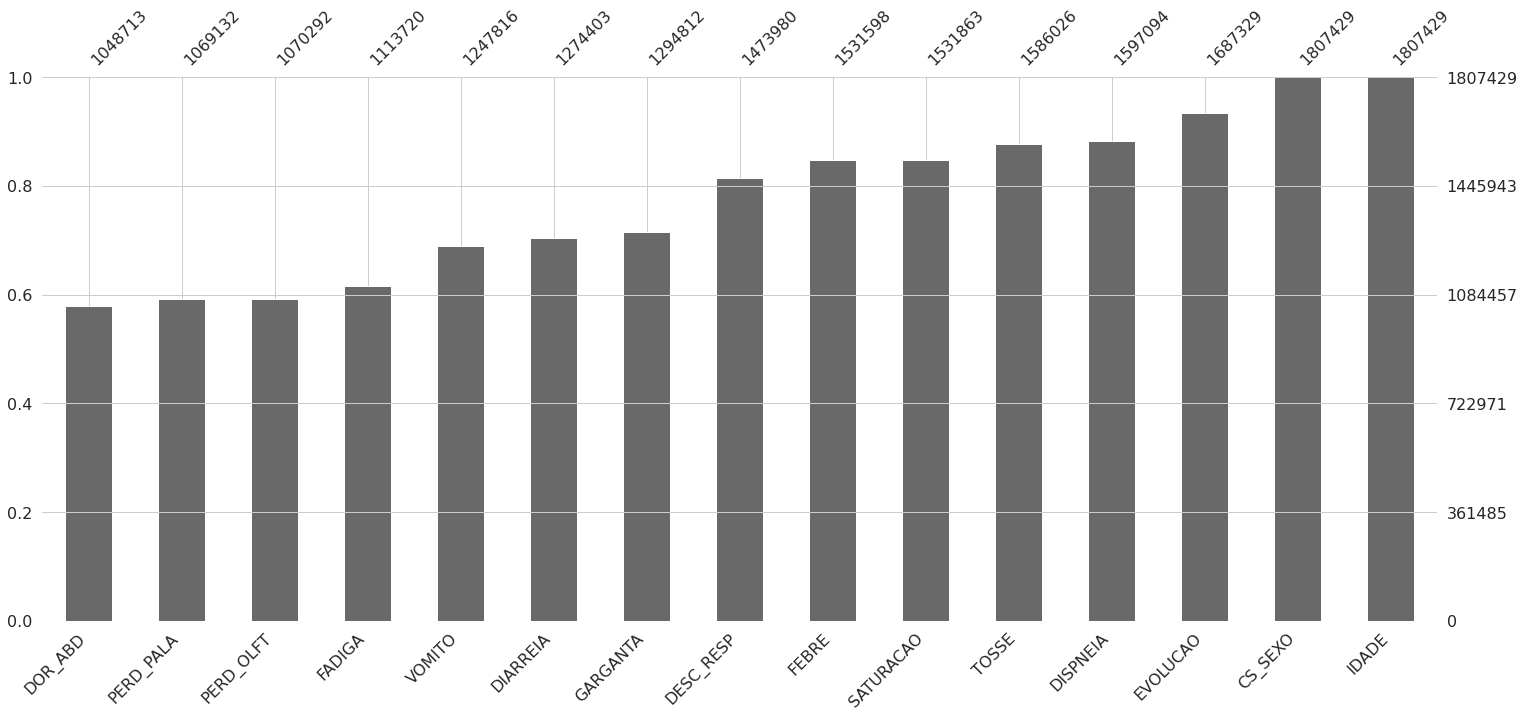

In [14]:
fig = msno.bar(aux, sort='ascending', labels=True) # fontsize=7
fig_copy = fig.get_figure()
fig_copy.savefig(f'{PATH_RESULT}/plots/missing/c1/features-bar.png')

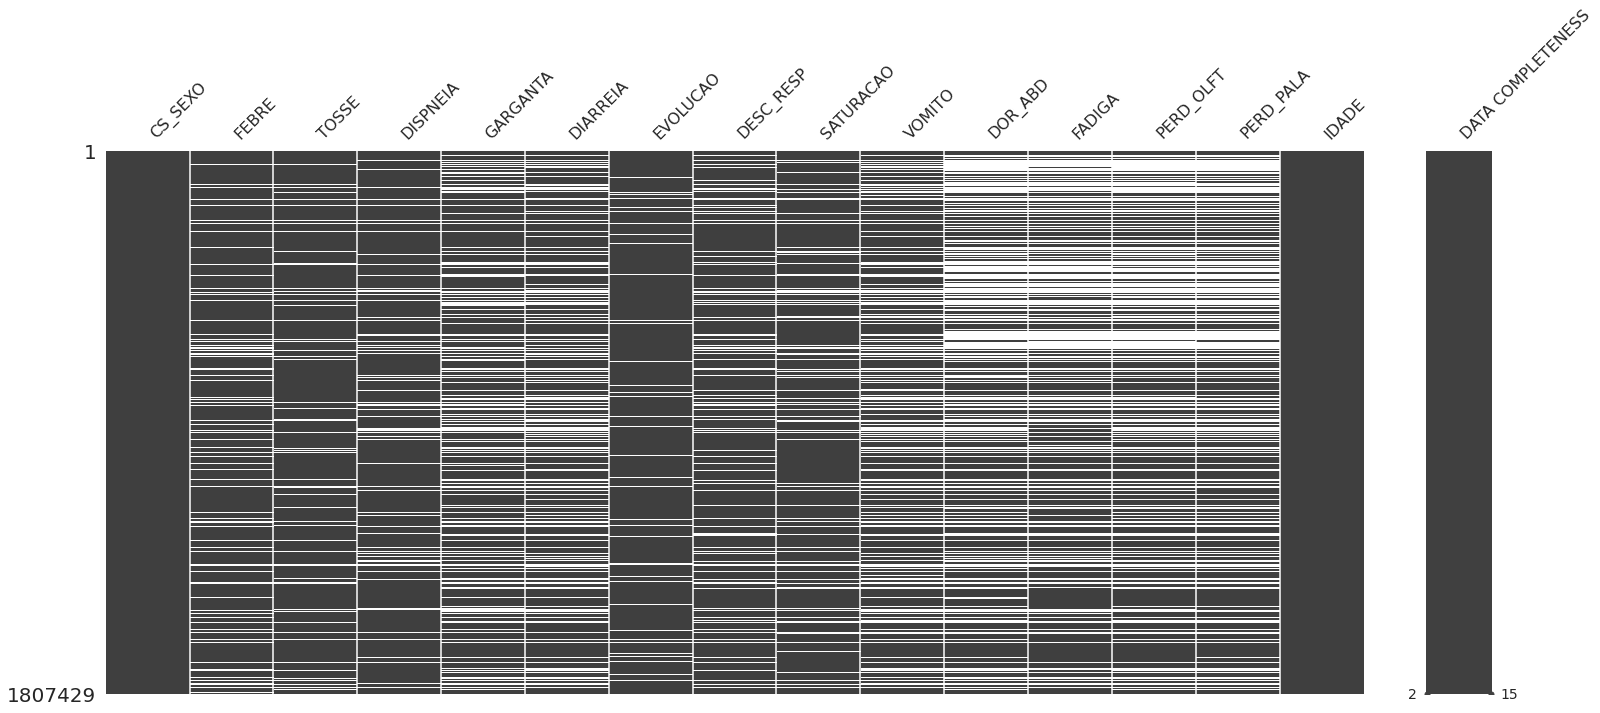

In [15]:
fig = msno.matrix(aux, labels=True)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{PATH_RESULT}/plots/missing/c1/features-matrix.png')

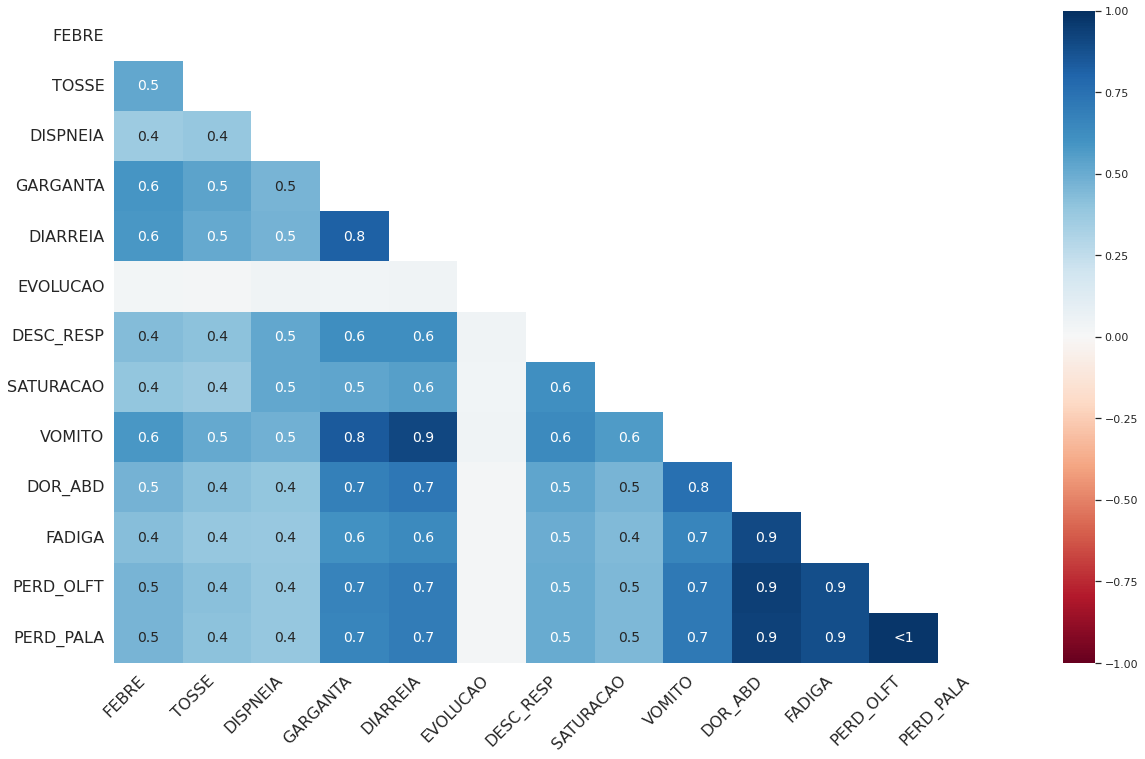

In [16]:
fig = msno.heatmap(aux, labels=True)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{PATH_RESULT}/plots/missing/c1/feature-heatmap.png')

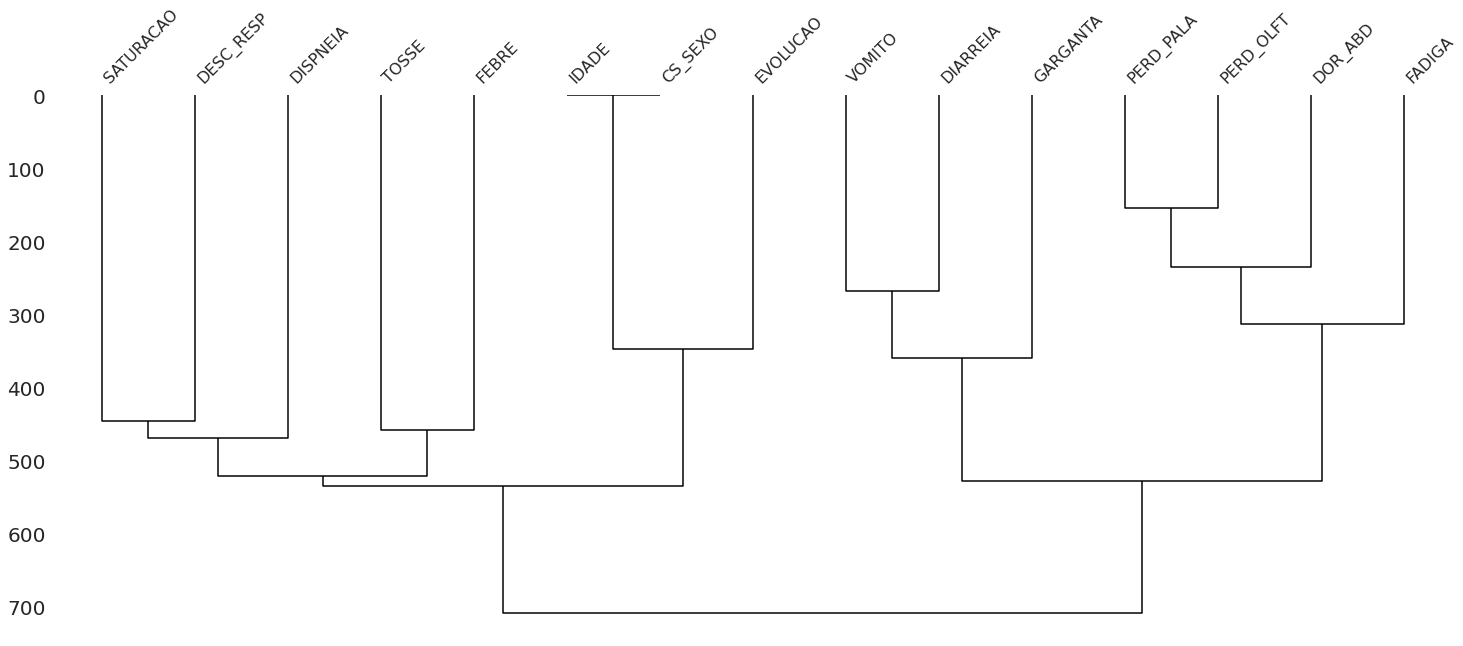

In [17]:
fig = msno.dendrogram(aux)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{PATH_RESULT}/plots/missing/c1/feature-dendrogram.png')

### Refine

In [18]:
df = spark.read.parquet(f'{PATH_DATA}/prepare/c1/1-feature-selection.parquet')

if EVOLUCAO values is 1, do nothing <br>
if EVOLUCAO values is 2, set class 0 (Óbito) <br>
else set class None

In [19]:
df = df.withColumn(
    'EVOLUCAO',
    when(col('EVOLUCAO') == 1, 1) \
    .when(col('EVOLUCAO') == 2, 0)
)

removing all rows that EVOLUCAO is null

In [20]:
df = df.select('*').where(col('EVOLUCAO').isNotNull())

In [21]:
df.write.mode('overwrite').parquet(f'{PATH_DATA}/prepare/c1/2-refine.parquet')

#### Plots

In [6]:
df = spark.read.parquet(f'{PATH_DATA}/prepare/c1/2-refine.parquet')

In [7]:
df.count()

1641633

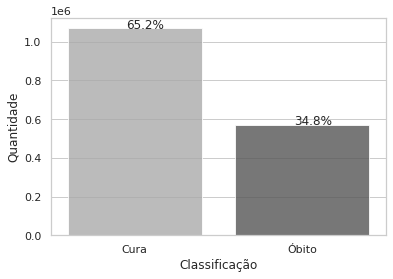

In [23]:
aux = df.groupBy('EVOLUCAO') \
    .count() \
    .withColumn(
        'EVOLUCAO',
        when(col('EVOLUCAO') == 0, 'Óbito').otherwise('Cura')
    ).toPandas()
ax = sns.barplot(x=aux['EVOLUCAO'].values, y=aux['count'].values, palette="gray_r", alpha=0.8)
# plt.title('Balanço das classes')
# plt.yticks(size=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Classificação', fontsize=12)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/aux['count'].sum())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

out = f'{PATH_RESULT}/plots/balance/c1'
pathlib.Path(out).mkdir(parents=True, exist_ok=True)

fig = ax.get_figure()
fig.savefig(f'{out}/general.png')
plt.show()

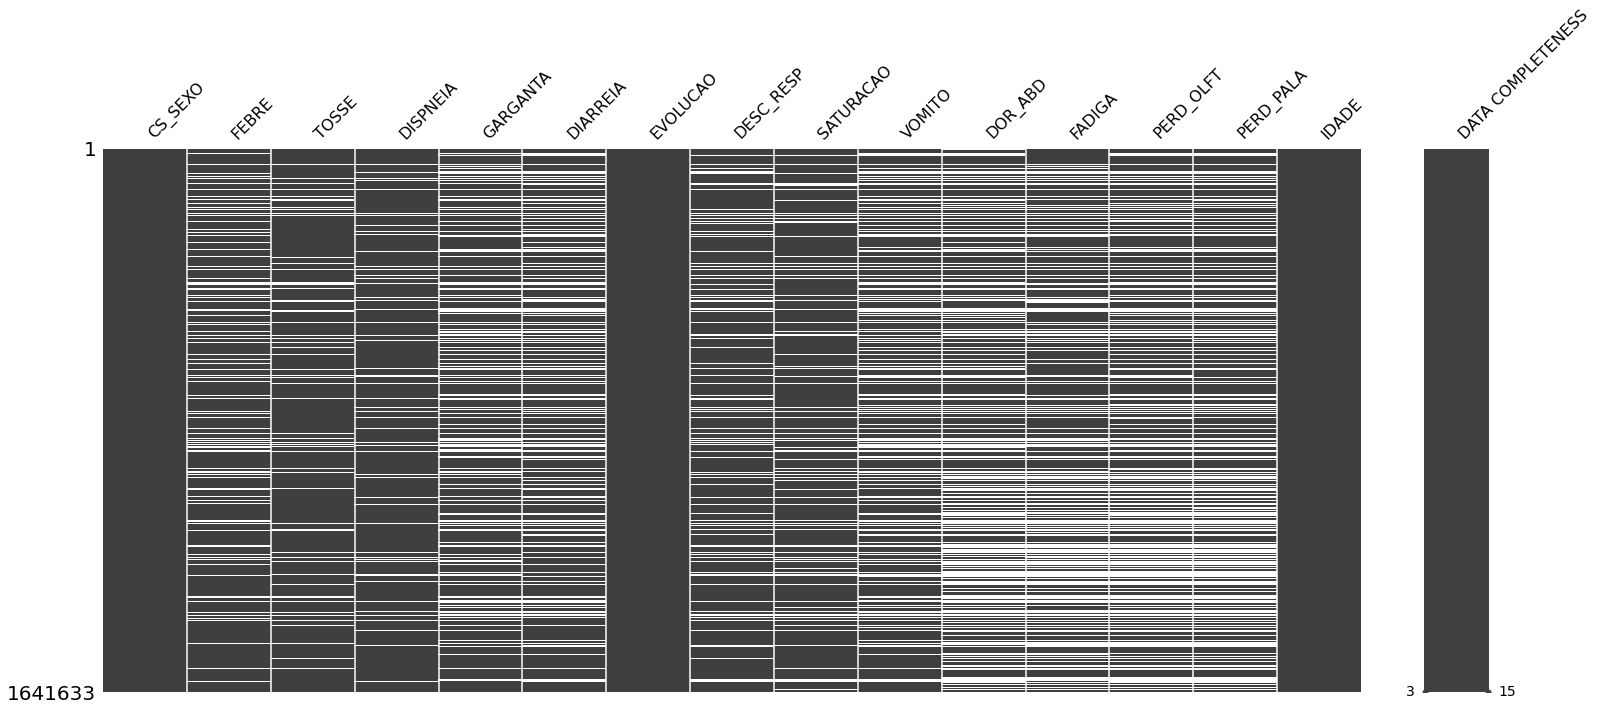

In [9]:
aux = df.toPandas()
fig = msno.matrix(aux, labels=True)
fig_copy = fig.get_figure()
fig_copy.savefig(f'{PATH_RESULT}/plots/missing/c1/final.png')

In [11]:
aux.dropna().shape[0]

910428

In [10]:
aux.dropna().shape[0]*100/1641633

55.45868047243202

### Enrich

In [24]:
df = spark.read.parquet(f'{PATH_DATA}/prepare/c1/2-refine.parquet')

change null for class 0

In [25]:
df = df.withColumns({
    c: when(col(c).isNull(), 0).otherwise(col(c)) for c in df.columns
})

In [26]:
df.write.mode('overwrite').parquet(f'{PATH_DATA}/prepare/c1/3-enrich.parquet')

developed by [patricksferraz](https://github.com/patricksferraz)